# Test the sample and distributional accuracy of the GNN-based probabilistic models

In [1]:
import numpy as np
import torch
from torchvision import transforms
import numpy as np
import tqdm

import dgn4cfd as dgn 

In [2]:
device = torch.device('cuda:0')

Settings:

In [3]:
DATASET = dgn.datasets.DatasetUrl.pOnWingTrain
NUM_DENOISING_STEPS = 50
SIM_IDX = 3

Load the models:
- Diffusion Graph Net (DGN)
- Latent Diffusion Graph Net (LDGN)
- Vanilla Graph Net
- Bayesian Graph Net
- Gaussian Mixure Graph Net
- Variational Graph Autoencoder (VGAE)

In [4]:
# Diffusion Graph Net
DGN = dgn.nn.DiffusionGraphNet(
    checkpoint = "./checkpoints/dgn-nt250.chk",
    device     = device,
)

# Latent Diffusion Graph Net
LDGN = dgn.nn.LatentDiffusionGraphNet(
    autoencoder_checkpoint = "./checkpoints/ae-nt250.chk",
    checkpoint             = "./checkpoints/ldgn-nt250.chk",
    device                 = device,
)

Load a dataset

In [5]:
path = DATASET
transform = transforms.Compose([
    dgn.transforms.ScaleEdgeAttr(0.015),
    dgn.transforms.EdgeCondFreeStream(normals='loc'),
    dgn.transforms.ScaleAttr('target', vmin=-1850,  vmax=400),
    dgn.transforms.MeshCoarsening(
        num_scales      =  6,
        rel_pos_scaling = [0.015, 0.03, 0.06, 0.12, 0.2, 0.4],
        scalar_rel_pos  = True, 
    ),
])
dataset = dgn.datasets.pOnWing(
    path          = path,
    T             = 250,
    transform     = transform,
    preload       = False,
)
print('Number of samples:', len(dataset))

T = 2500 # The grouth-truth trajectory length

Number of samples: 16


## Sample Inference

====== DGN ======
R2: 0.9862 at t=1047


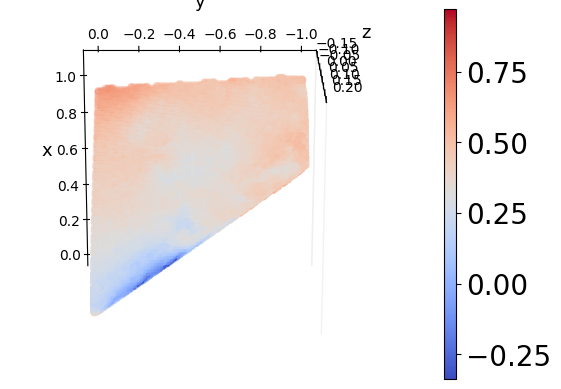

====== LDGN ======
R2: 0.9723 at t=1362


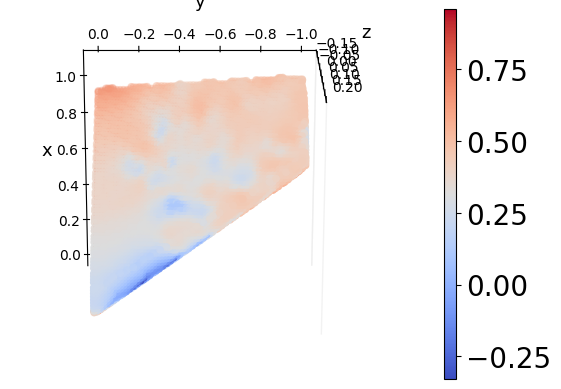

In [6]:
graph = dataset.get_sequence(SIM_IDX, n_in=T)

steps      = dgn.nn.diffusion.DiffusionStepsGenerator('linear', DGN.diffusion_process.num_steps)(NUM_DENOISING_STEPS) # Sample denoising steps for the DGN and LDGN

# DGN inference
pred = DGN.sample(graph, steps=steps)

# Compute the accuracy
targets = graph.target.split(1, dim=1)
r2 = [dgn.metrics.r2_accuracy(pred, target) for target in targets]
r2, t = np.max(r2), np.argmax(r2)
target = targets[t] # Ground-truth field closest to the prediction
print('====== DGN ======')
print(f"R2: {r2:.4f} at t={t}")

# Plot the results
graph.plot_pos_field(pred[:,0], s=20, azim=180, elev=110)


# LDGN inference
pred = LDGN.sample(graph, steps=steps)

# Compute the accuracy
targets = graph.target.split(1, dim=1)
r2 = [dgn.metrics.r2_accuracy(pred, target) for target in targets]
r2, t = np.max(r2), np.argmax(r2)
target = targets[t] # Ground-truth field closest to the prediction
print('====== LDGN ======')
print(f"R2: {r2:.4f} at t={t}")

# Plot the results
graph.plot_pos_field(pred[:,0], s=20, azim=180, elev=110)

## Distribution inference
Approximate the learned distributions by sampling many times

100%|██████████| 4000/4000 [1:28:36<00:00,  1.33s/it]


====== DGN ======
R2 of mean: 0.9966 R2 of std: 0.8961
Wasserstein-2 distance 1d: 0.0111
Wasserstein-2 distance nd: 2.5495
	-Mean:


/home/lino/miniconda3/envs/dgn/lib/python3.12/site-packages/ot/lp/__init__.py:580: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


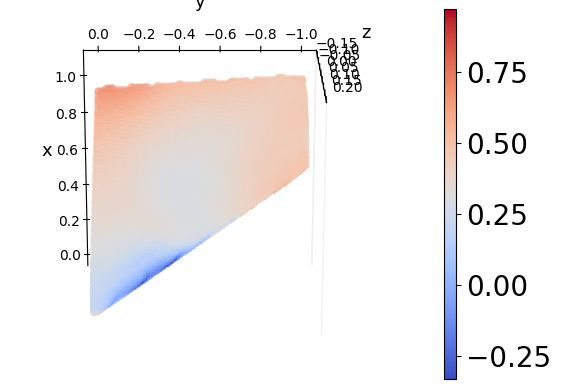

	-Std:


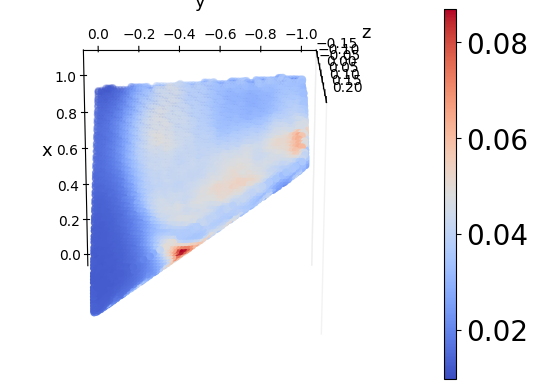

100%|██████████| 4000/4000 [1:00:42<00:00,  1.10it/s]


====== LDGN ======
R2 of mean: 0.9963 R2 of std: 0.9580
Wasserstein-2 distance 1d: 0.0118
Wasserstein-2 distance nd: 2.5162
	-Mean:


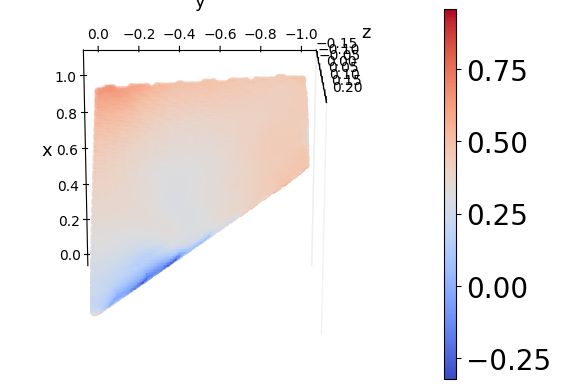

	-Std:


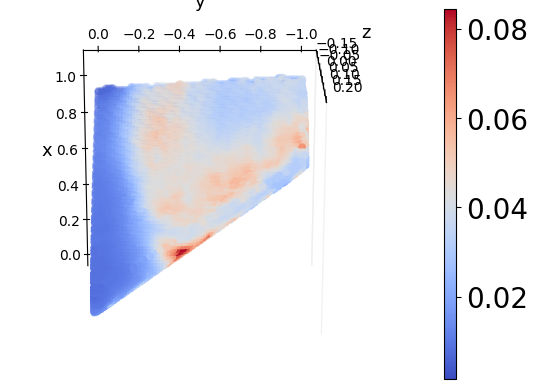

<vtkmodules.vtkCommonDataModel.vtkPolyData(0x2ab22610) at 0x7145b224d6c0>

In [7]:
NUM_SAMPLES = 4000

graph = dataset.get_sequence(SIM_IDX, n_in=T)
gt_mean = graph.target.mean(dim=1)
gt_std  = graph.target.std (dim=1)

steps = dgn.nn.diffusion.DiffusionStepsGenerator('linear', DGN.diffusion_process.num_steps)(NUM_DENOISING_STEPS)


# DGN inference
pred_list = []
for _ in tqdm.tqdm(range(NUM_SAMPLES)):
    pred_list.append(
        DGN.sample(graph, steps=steps).cpu()
    )
pred = torch.concat(pred_list, dim=1) # (num_nodes, num_samples)
mean = pred.mean(dim=1)
std  = pred.std (dim=1)
# Compute the accuracy of the mean and std
mean_r2 = dgn.metrics.r2_accuracy(mean, gt_mean)
std_r2  = dgn.metrics.r2_accuracy(std , gt_std )
print('====== DGN ======')
print(f"R2 of mean: {mean_r2:.4f}", f"R2 of std: {std_r2:.4f}")
# Compute the Wasserstein-2 distance
w2_distance_1d = dgn.metrics.w2_distance_1d(pred, graph.target)
w2_distance_nd = dgn.metrics.w2_distance_nd(pred, graph.target)
print(f"Wasserstein-2 distance 1d: {w2_distance_1d:.4f}")
print(f"Wasserstein-2 distance nd: {w2_distance_nd:.4f}")
# Plot the results
print('\t-Mean:')
graph.plot_pos_field(mean, s=20, azim=180, elev=110)
print('\t-Std:')
graph.plot_pos_field(std , s=20, azim=180, elev=110)
# Save as vtk
# This creates a point cloud. To visualize it in Paraview, use the 'Point Gaussian' representation or create a mesh with the 'Delaunay 3D' filter
dgn.plot.convert_to_vtk(
    pos       = graph.pos,
    fields    = mean,
    filename  =  'dgn_mean.vtk',
    fieldname = 'mean',
)
dgn.plot.convert_to_vtk(
    pos       = graph.pos,
    fields    = std,
    filename  =  'dgn_std.vtk',
    fieldname = 'std',
)


# LDGN inference
pred_list = []
for _ in tqdm.tqdm(range(NUM_SAMPLES)):
    pred_list.append(
        LDGN.sample(graph, steps=steps).cpu()
    )
pred = torch.concat(pred_list, dim=1) # (num_nodes, num_samples)
mean = pred.mean(dim=1)
std  = pred.std (dim=1)
# Compute the accuracy of the mean and std
mean_r2 = dgn.metrics.r2_accuracy(mean, gt_mean)
std_r2  = dgn.metrics.r2_accuracy(std , gt_std )
print('====== LDGN ======')
print(f"R2 of mean: {mean_r2:.4f}", f"R2 of std: {std_r2:.4f}")
# Compute the Wasserstein-2 distance
w2_distance_1d = dgn.metrics.w2_distance_1d(pred, graph.target)
w2_distance_nd = dgn.metrics.w2_distance_nd(pred, graph.target)
print(f"Wasserstein-2 distance 1d: {w2_distance_1d:.4f}")
print(f"Wasserstein-2 distance nd: {w2_distance_nd:.4f}")
# Plot the results
print('\t-Mean:')
graph.plot_pos_field(mean, s=20, azim=180, elev=110)
print('\t-Std:')
graph.plot_pos_field(std , s=20, azim=180, elev=110)
# Save as vtk
# This creates a point cloud. To visualize it in Paraview, use the 'Point Gaussian' representation or create a mesh with the 'Delaunay 3D' filter
dgn.plot.convert_to_vtk(
    pos       = graph.pos,
    fields    = mean,
    filename  =  'ldgn_mean.vtk',
    fieldname = 'mean',
)
dgn.plot.convert_to_vtk(
    pos       = graph.pos,
    fields    = std,
    filename  =  'ldgn_std.vtk',
    fieldname = 'std',
)